In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
from shapely.geometry import Point, Polygon
from shapely.affinity import scale
from shapely.strtree import STRtree

import json
from rtree import index

import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
adata_dir = "data_level_1/adata_slide2/"
he_image_dir = "data_level_1/he_registered_old/"
pc_dir = "data_level_1/phenocycler_registered/"
polygon_dir  = "/data/projects/robin/segmentation/output-new-seg/segmentation_polygons.json"

with open(polygon_dir, 'r') as file:
    polygon_dict = json.load(file)

In [3]:
cell_names = [str(polygon_dict['geometries'][i]['cell']) for i in range(len(polygon_dict['geometries']))]
cell_coordinates = [polygon_dict['geometries'][i]['coordinates'][0] for i in range(len(polygon_dict['geometries']))]
cell_names = np.array(cell_names)
cell_names[0], cell_coordinates[0]

('185983',
 [[3714.5618, 20479.88],
  [3714.3374, 20482.264],
  [3716.8914, 20483.77],
  [3718.359, 20482.613],
  [3718.314, 20482.37],
  [3717.9287, 20478.893],
  [3717.011, 20478.408],
  [3715.521, 20479.059],
  [3714.5618, 20479.88]])

In [4]:
sample = 'X1'
adata = sc.read_h5ad(adata_dir + f'{sample}.h5ad')
he_image = plt.imread(he_image_dir + f'{sample}.tiff')
adata.shape

(86811, 480)

In [5]:
slide_id = adata.obs['Slide_ID'][0]
adata.uns['spatial'][slide_id]['images']['he_downscaled_aligned'] = he_image  
adata.uns['spatial'][slide_id]['scalefactors']['tissue_he_downscaled_aligned_scalef'] = 1
adata.uns['spatial'][slide_id]['scalefactors']['tissue_dapi_LEVEL1_cropped_scalef'] = 1

In [6]:
cell_name = [i.split('-')[1] for i in adata.obs.index]
adata.obs['cell_name'] = cell_name
adata = adata[adata.obs['cell_name'].isin(cell_names)]
adata.shape

(86811, 480)

In [167]:
ch = 0
adata.obs[f'Phenocycler_Channel{ch+1}'] = 0

pc_image = plt.imread(pc_dir + f"Phenocycler_Channel{(ch+1):02}_{sample}_Level2_registered.tiff")
w, h = pc_image.shape

In [213]:
x_shift = adata.obs['x'][0] - adata.obsm['spatial'][0, 0]
y_shift = adata.obs['y'][0] - adata.obsm['spatial'][0, 1]
x_shift, y_shift

(4965.0, 15767.0)

In [230]:
adata.obs.loc[adata.obs['cell_name'] == '178858']

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,celltype_l1_codes,celltype_l1_prob,Slide_ID,sample,label,cell_name,Phenocycler_Channel2,Phenocycler_Channel7,Phenocycler_Channel1,Phenocycler_Channel9


In [220]:
i, j = 579, 2051
pc_image[i, j]

coords = cell_coordinates[np.where(cell_names == '183840')[0].item()]
coords = np.array(coords)
coords[:,0] = coords[:,0] - x_shift
coords[:,1] = coords[:,1] - y_shift
coords

array([[ 569.546 , 2028.953 ],
       [ 568.02  , 2029.416 ],
       [ 567.5015, 2030.441 ],
       [ 568.9956, 2030.271 ],
       [ 571.8433, 2029.482 ],
       [ 569.546 , 2028.953 ]])

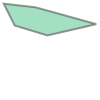

In [221]:
polygon_obj = Polygon(coords)
polygon_obj

In [222]:
point = Point([i, j])
polygon_obj = scale(polygon_obj, xfact=2, yfact=2, origin='centroid')
polygon_obj.contains(point)

False

In [223]:
list(spatial_index.intersection((i, j, i, j)))

[178858]

In [151]:
# polygons = []
# for name, coords in tqdm(zip(cell_names, cell_coordinates)):
#     if (adata.obs['cell_name'] == name).sum():
#         if len(coords) > 2:
#             polygon_obj = Polygon(coords)
#             polygon_obj = scale(polygon_obj, xfact=2, yfact=2, origin='centroid')
#             polygons.append((name, polygon_obj))

In [152]:
existing_cells = set(adata.obs['cell_name'])

polygons = []
for name, coords in tqdm(zip(cell_names, cell_coordinates)):
    if name in existing_cells and len(coords) > 2:
        coords = np.array(coords)
        coords[:,0] = coords[:,0] - x_shift
        coords[:,1] = coords[:,1] - y_shift
        polygon_obj = Polygon(coords)
        polygon_obj = scale(polygon_obj, xfact=2, yfact=2, origin='centroid')
        polygons.append((name, polygon_obj))

378695it [00:08, 44545.35it/s]


In [69]:
names, polygon_objects = zip(*polygons)
names[0], polygon_objects[0]

('221120',
 <POLYGON ((2156.587 3939.935, 2150.764 3935.975, 2143.382 3933.579, 2145.81 ...>)

In [101]:
candidate_polygons = polygon_tree.query(point)

In [104]:
# polygon_tree = STRtree(polygon_objects)
# pic_val_sum = {name: 0 for name in names}
# existing_cells = set(adata.obs['cell_name'])

# for i in tqdm(range(w)):
#     for j in range(h):
#         pic_val = pc_image[i, j]
#         if pic_val > 0:
#             point = Point(i, j)
            
#             candidate_polygons = polygon_tree.query(point)
            
#             for polygon, name in zip(candidate_polygons, names):
#                 if polygon.contains(point):
#                     pic_val_sum[name] += pic_val
#                     break

In [ ]:
# pic_val_sum = {name: 0 for name in cell_names}

# for i in tqdm(range(w)):
#     for j in range(h):
#         pic_val = pc_image[i, j]
#         if pic_val > 0:
#             point = Point(i, j)
#             for name_n, polygon_n  in polygons:
#                 is_inside = polygon_n.contains(point)
#                 if is_inside:
#                     pic_val_sum[name_n] += pic_val
#                     print("Hi")
#                     break

In [193]:
spatial_index = index.Index()
existing_cells = set(adata.obs['cell_name'])
polygons = []

for idx, (cell_name, coords) in tqdm(enumerate(zip(cell_names, cell_coordinates))):
    if len(coords) > 2:
        coords = np.array(coords)
        coords[:,0] = coords[:,0] - x_shift
        coords[:,1] = coords[:,1] - y_shift
        polygon = Polygon(coords)
        polygon = scale(polygon, xfact=1, yfact=1, origin='centroid')
        polygons.append((cell_name, polygon))
        spatial_index.insert(idx, polygon.bounds)

378695it [01:10, 5367.47it/s]


In [200]:
possible_matches

[]

In [199]:
pic_val_sum = {name: 0 for name in cell_names}

for i in tqdm(range(w)):
    for j in range(h):
        pic_val = pc_image[i, j]
        if pic_val > 0:
            point = Point(i, j)

            possible_matches = list(spatial_index.intersection((i, j, i, j)))
            
            for n in possible_matches:
                print(possible_matches)
                if n < len(polygons):
                    cell_name_n, polygon_obj = polygons[n]
                    if polygon_obj.contains(point):
                        pic_val_sum[cell_name_n] += pic_val
                        print(len(possible_matches))
                        # break

  1%|          | 70/6631 [00:00<00:19, 343.16it/s]

0 2316
1 2316
2 2413
3 2311
4 2299
5 2295
6 2294
7 2235
8 2277
9 2223
10 2214
11 768
12 768
13 769
14 770
15 1002
16 2215
17 2215
18 2199
19 2312
20 2319
21 2319
22 2239
23 2234
24 2217
25 2214
26 2209
27 2274
28 2181
29 2180
30 2181
31 2181
32 2197
33 2197
34 2249
35 2258
36 2218
37 2217
38 2325
39 2248
40 2291
41 2437
42 2201
43 2525
44 2508
45 2331
46 2326
47 643
48 643
49 645
50 2228
51 2219
52 2218
53 2211
54 2212
55 2203
56 2286
57 2286
58 2521
59 2445
60 2523
61 2396
62 2396
63 2237
64 322
65 2230
66 2222
67 2280
68 2598
69 2397
70 2199
71 2202
72 2202
73 2202
74 2398
75 2398
76 2364
77 2387
78 2353
79 2350
80 2247
81 2239
82 2216
83 1018
84 210
85 210


  2%|▏         | 145/6631 [00:00<00:18, 358.52it/s]

86 209
87 2208
88 2208
89 2195
90 2374
91 428
92 983
93 2199
94 2194
95 2349
96 2239
97 2226
98 2225
99 2215
100 2208
101 2204
102 2245
103 2236
104 2198
105 2197
106 2197
107 2199
108 2360
109 2347
110 2347
111 2338
112 2314
113 2232
114 2224
115 2207
116 2203
117 2203
118 2240
119 2199
120 2539
121 2537
122 2183
123 2375
124 2360
125 2351
126 2350
127 2324
128 2313
129 2297
130 2570
131 2282
132 2472
133 2207
134 2204
135 1002
136 998
137 1000
138 1000
139 332
140 2365
141 2359
142 2341
143 788
144 2306
145 2411
146 2288
147 2289
148 2284
149 2273
150 2260
151 313
152 311
153 311
154 310
155 310
156 311
157 218
158 312
159 61
160 311
161 313
162 2283
163 2272
164 227
165 2257
166 2246
167 338
168 339
169 339
170 237
171 234
172 232
173 230
174 229
175 228
176 227
177 226
178 226
179 226
180 226
181 228
182 231
183 245
184 245
185 245
186 244
187 247
188 247
189 247
190 248
191 251
192 251
193 251
194 2265
195 2267
196 2291
197 2248
198 2402
199 2221
200 2693
201 2227
202 2513
203 250

  5%|▌         | 342/6631 [00:00<00:16, 374.85it/s]

210 2477
211 2466
212 2450
213 2249
214 2323
215 2319
216 2318
217 2262
218 2262
219 2456
220 2323
221 2489
222 2489
223 2237
224 2218
225 2301
226 2357
227 772
228 2327
229 2325
230 2323
231 435
232 2287
233 2405
234 2275
235 2429
236 2247
237 2248
238 2233
239 2205
240 2271
241 2278
242 2335
243 2335
244 1466
245 554
246 554
247 554
248 554
249 553
250 552
251 550
252 551
253 551
254 552
255 2226
256 2226
257 2226
258 2225
259 2225
260 2228
261 2228
262 2290
263 2288
264 2283
265 2267
266 2269
267 2261
268 2250
269 2190
270 2190
271 2190
272 2206
273 2444
274 2381
275 178
276 2377
277 2348
278 2342
279 2334
280 2334
281 2323
282 2323
283 2267
284 2246
285 2250
286 2250
287 2236
288 2224
289 2205
290 2215
291 500
292 2237
293 2237
294 2361
295 2361
296 2342
297 2340
298 2340
299 2332
300 2329
301 2327
302 2308
303 2246
304 2229
305 2198
306 2197
307 2197
308 2196
309 2199
310 2199
311 2246
312 2250
313 2326
314 2273
315 2273
316 2282
317 2281
318 2203
319 2195
320 2195
321 2200
322 22

  7%|▋         | 454/6631 [00:01<00:18, 342.27it/s]

342 2235
343 2250
344 2252
345 2208
346 2228
347 2230
348 2255
349 2255
350 2257
351 2352
352 2352
353 2350
354 2340
355 2338
356 2337
357 2326
358 2235
359 2215
360 2217
361 2211
362 2211
363 2211
364 2256
365 2239
366 2239
367 2236
368 2261
369 2274
370 2361
371 2361
372 2361
373 2360
374 2353
375 2349
376 2349
377 2342
378 2337
379 2338
380 2226
381 2212
382 2208
383 2214
384 2244
385 2273
386 2223
387 2222
388 2223
389 2260
390 2262
391 2283
392 2358
393 2354
394 2354
395 2349
396 2205
397 2205
398 2205
399 2205
400 2226
401 2215
402 2215
403 2216
404 2227
405 2227
406 2241
407 2389
408 2384
409 2381
410 2379
411 2355
412 2335
413 2334
414 2330
415 2207
416 2206
417 2213
418 2224
419 2228
420 2229
421 2229
422 2439
423 2401
424 2401
425 2401
426 2339
427 2321
428 2327
429 2318
430 2370
431 2217
432 2219
433 2227
434 2227
435 2208
436 2208
437 2259
438 2301
439 2418
440 2418
441 2411
442 2339
443 2319
444 2304
445 2277
446 2266
447 2224
448 2215
449 2213
450 2212
451 2212
452 2212
4

  8%|▊         | 557/6631 [00:01<00:18, 331.62it/s]

454 2209
455 2364
456 2421
457 2294
458 2292
459 2299
460 2299
461 2271
462 2254
463 2212
464 2210
465 2210
466 2212
467 2244
468 2244
469 2244
470 2244
471 2243
472 2247
473 2247
474 2369
475 2415
476 2290
477 2289
478 2286
479 2302
480 2325
481 2270
482 2270
483 2267
484 2268
485 2210
486 2210
487 2211
488 2211
489 2217
490 2217
491 2242
492 2242
493 2242
494 2304
495 2288
496 2288
497 2283
498 2281
499 2368
500 2340
501 2328
502 2275
503 2233
504 2218
505 2231
506 2232
507 2232
508 2233
509 2233
510 2234
511 2251
512 2249
513 2251
514 2251
515 2251
516 2251
517 2251
518 2251
519 2233
520 2220
521 2231
522 2231
523 2233
524 2237
525 2304
526 2304
527 2330
528 2296
529 2287
530 2287
531 2280
532 2229
533 2229
534 2216
535 2231
536 2335
537 2257
538 2328
539 2313
540 2311
541 2310
542 2309
543 2301
544 2536
545 2289
546 2239
547 2231
548 2228
549 2230
550 2271
551 2271
552 2449
553 2449
554 2489
555 2467
556 2435


 10%|█         | 669/6631 [00:01<00:16, 357.59it/s]

557 2427
558 2427
559 2248
560 2248
561 2391
562 2389
563 2373
564 2373
565 2364
566 2459
567 2357
568 2349
569 2349
570 2349
571 2379
572 2258
573 2261
574 2429
575 2433
576 2317
577 2269
578 2271
579 2390
580 2252
581 2375
582 2335
583 2102
584 2103
585 2103
586 2236
587 2236
588 2233
589 2233
590 2233
591 2285
592 1906
593 1904
594 2291
595 2292
596 1929
597 1928
598 2327
599 1926
600 1940
601 1935
602 1922
603 1918
604 1918
605 1918
606 1917
607 1916
608 1916
609 1821
610 1915
611 1915
612 1915
613 1934
614 1913
615 1912
616 1911
617 1929
618 1929
619 1929
620 1929
621 1928
622 1927
623 1911
624 1911
625 1910
626 1910
627 1928
628 1929
629 1928
630 1904
631 1902
632 1929
633 1929
634 1929
635 1914
636 1913
637 1911
638 1910
639 1904
640 1721
641 1900
642 1790
643 1898
644 1901
645 1901
646 1901
647 1902
648 1902
649 1902
650 1902
651 1842
652 1843
653 1843
654 1931
655 1931
656 1860
657 1850
658 1839
659 1839
660 1840
661 1845
662 1845
663 1845
664 1845
665 1844
666 1844
667 1840
6

 12%|█▏        | 785/6631 [00:02<00:16, 364.34it/s]

669 1841
670 1839
671 1839
672 1837
673 1837
674 1834
675 1832
676 1835
677 1908
678 1906
679 1905
680 1831
681 1832
682 1832
683 1911
684 1909
685 1907
686 1907
687 1906
688 1906
689 1831
690 1828
691 1878
692 1865
693 1864
694 1874
695 1874
696 1829
697 1828
698 1848
699 1848
700 1891
701 1888
702 1859
703 1838
704 1852
705 1852
706 1852
707 1849
708 1817
709 1817
710 1852
711 1762
712 1765
713 1851
714 1831
715 1852
716 1812
717 1854
718 1856
719 1989
720 2396
721 2354
722 2342
723 1865
724 1867
725 2317
726 1894
727 2254
728 2237
729 1823
730 1825
731 2230
732 2230
733 2230
734 2230
735 2208
736 2210
737 2227
738 2227
739 2336
740 2332
741 2181
742 1997
743 2169
744 1968
745 1968
746 2229
747 2227
748 2075
749 2000
750 1999
751 2020
752 2018
753 2018
754 2060
755 1789
756 1789
757 2063
758 2063
759 2063
760 2063
761 2063
762 2063
763 1811
764 1995
765 1995
766 1793
767 2017
768 2293
769 2094
770 1774
771 1772
772 1772
773 1922
774 2184
775 1863
776 1854
777 1854
778 1814
779 1832
7

 14%|█▎        | 899/6631 [00:02<00:15, 362.66it/s]

785 1786
786 1900
787 2228
788 2228
789 2231
790 1758
791 1756
792 1746
793 1727
794 2268
795 2263
796 2253
797 2248
798 2240
799 2238
800 2243
801 2227
802 2226
803 1769
804 1768
805 1769
806 1763
807 1769
808 1749
809 1747
810 2118
811 2107
812 2149
813 2149
814 2221
815 2221
816 2008
817 2005
818 2206
819 1934
820 2191
821 1772
822 1770
823 1769
824 1769
825 1769
826 1768
827 2067
828 2054
829 2047
830 2045
831 2109
832 2109
833 2109
834 1987
835 1953
836 1953
837 1935
838 1935
839 1769
840 1769
841 1769
842 1748
843 1747
844 2071
845 2110
846 1831
847 1825
848 1825
849 1825
850 1825
851 1825
852 1781
853 1789
854 2307
855 1770
856 1770
857 1769
858 2283
859 2274
860 2232
861 2007
862 2005
863 2233
864 2243
865 2243
866 2243
867 1785
868 2103
869 2252
870 2251
871 1764
872 2301
873 2293
874 1824
875 2290
876 2210
877 2207
878 2207
879 2074
880 2177
881 2003
882 2126
883 1969
884 1766
885 2273
886 2273
887 2252
888 2252
889 2270
890 2270
891 1845
892 2303
893 2303
894 2056
895 2052
8

 15%|█▌        | 1009/6631 [00:02<00:15, 355.19it/s]

899 1981
900 2020
901 2103
902 2230
903 1925
904 1926
905 2274
906 2358
907 2351
908 2336
909 2251
910 1870
911 2086
912 1834
913 2287
914 2280
915 2278
916 2269
917 2260
918 2260
919 1958
920 2232
921 1707
922 1707
923 2156
924 2165
925 2263
926 2233
927 2231
928 2239
929 2089
930 2277
931 2276
932 2272
933 2270
934 2258
935 2258
936 2250
937 2022
938 2233
939 1967
940 2193
941 2173
942 2208
943 2208
944 2140
945 2208
946 2241
947 2283
948 2072
949 2069
950 2065
951 2049
952 2041
953 1993
954 2019
955 2020
956 2013
957 2007
958 2007
959 1965
960 1965
961 1929
962 2117
963 1949
964 2243
965 2247
966 2282
967 2091
968 2204
969 2207
970 2160
971 2154
972 2007
973 2007
974 1986
975 1835
976 1838
977 1946
978 2212
979 2089
980 2141
981 2139
982 2069
983 2174
984 2160
985 2052
986 2242
987 2037
988 2025
989 2070
990 1975
991 1998
992 1998
993 2012
994 1809
995 2291
996 2289
997 1811
998 1807
999 1807
1000 1807
1001 1807
1002 1809
1003 1809
1004 1809
1005 1809
1006 1806
1007 2241
1008 2209


 17%|█▋        | 1119/6631 [00:03<00:15, 360.81it/s]

1009 2298
1010 2298
1011 1971
1012 1971
1013 1915
1014 2161
1015 1912
1016 1818
1017 1818
1018 1819
1019 2142
1020 2133
1021 2122
1022 2274
1023 1767
1024 2185
1025 2182
1026 2289
1027 2175
1028 2169
1029 2244
1030 1733
1031 2153
1032 2153
1033 2136
1034 2201
1035 2091
1036 1923
1037 2151
1038 2188
1039 1758
1040 2071
1041 2109
1042 2270
1043 1900
1044 2265
1045 2144
1046 2032
1047 2032
1048 1956
1049 1935
1050 1934
1051 2066
1052 1927
1053 2065
1054 2064
1055 2063
1056 2085
1057 1906
1058 1905
1059 1903
1060 1901
1061 1892
1062 1910
1063 1910
1064 1988
1065 1931
1066 1931
1067 1759
1068 1760
1069 1977
1070 2140
1071 1913
1072 2055
1073 2061
1074 2061
1075 2061
1076 2285
1077 2284
1078 2277
1079 1870
1080 1826
1081 1931
1082 2198
1083 2142
1084 1975
1085 2040
1086 2272
1087 2274
1088 2090
1089 2293
1090 2185
1091 2277
1092 2045
1093 2045
1094 2047
1095 2047
1096 1949
1097 2248
1098 2137
1099 2200
1100 2248
1101 1752
1102 2096
1103 2183
1104 2029
1105 2069
1106 2187
1107 2161
1108 1811


KeyboardInterrupt: 

In [ ]:
for cell_name, value in tqdm(pic_val_sum.items()):
    if value > 0:
        adata.obs.loc[adata.obs['cell_name'] == cell_name, f'Phenocycler_Channel{ch+1}'] += value

In [175]:
(adata.obs[f'Phenocycler_Channel{ch+1}']).sum()

253586

In [176]:
(adata.obs[f'Phenocycler_Channel{ch+1}'] > 0).sum() / len(adata.obs[f'Phenocycler_Channel{ch+1}'])

0.0006335602631002983

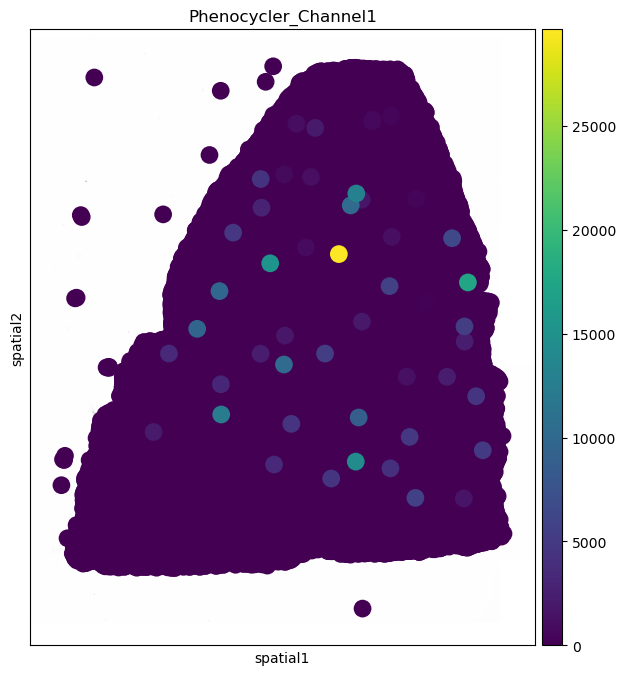

In [178]:
fig, ax = plt.subplots(figsize=(8, 8))
slide_id = adata.obs['Slide_ID'][0]
sc.pl.spatial(adata,
              library_id = slide_id,
              img_key = 'dapi_LEVEL1_cropped',
              color = f'Phenocycler_Channel{ch+1}',
              size = 5,
              ax = ax,
              show = True)

In [884]:
adata_dir = "data_level_1/adata_slide2/"
he_image_dir = "data_level_1/he_registered_old/"
pc_dir = "data_level_1/phenocycler_registered/"

for sample in ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']:
    print(sample)
    adata = sc.read_h5ad(adata_dir + f'{sample}.h5ad')
    he_image = plt.imread(he_image_dir + f'{sample}.tiff')
    
    slide_id = adata.obs['Slide_ID'][0]
    adata.uns['spatial'][slide_id]['images']['he_downscaled_aligned'] = he_image  
    adata.uns['spatial'][slide_id]['scalefactors']['tissue_he_downscaled_aligned_scalef'] = 1
    adata.uns['spatial'][slide_id]['scalefactors']['tissue_dapi_LEVEL1_cropped_scalef'] = 1
    
    for i in range(13):
        pc_image = plt.imread(pc_dir + f"Phenocycler_Channel{(i+1):02}_{sample}_Level2_registered.tiff")
        adata.obs[f'Phenocycler_Channel{i+1}'] = [pc_image[int(np.round(j)), int(np.round(i))] for i, j in adata.obsm["spatial"]]
        # print(pc_image.shape, he_image.shape)
    adata.obs['sample'] = sample
    
    if sample == 'X1':
        adata_all = adata
    else:
        adata_all = adata_all.concatenate(adata) 
    print(adata_all.shape)

X1
(86811, 480)
X2
(116087, 480)
X3
(168976, 480)
X4
(199596, 480)
X5
(231888, 480)
X6
(277212, 480)
X7
(289602, 480)


In [900]:
adata_all.write_h5ad("data_level_1/adata_slide2_with_proteins_noX8_v2.h5ad")

In [901]:
# show dapi
# LEVEL = 1
# ID = adata.obs.Slide_ID.unique()[0]
# scale_factor = adata.uns["spatial"][ID]["scalefactors"][f"tissue_dapi_LEVEL{LEVEL}_scalef"]
# dapi = adata.uns["spatial"][ID]["images"][f"dapi_LEVEL{LEVEL}"+"_cropped"]
# dapi.shape
# adata.obs['dapi'] = [dapi[int(j), int(i)] for i, j in adata.obsm["spatial"]]
# adata.obsm["spatial"].min(axis=0), adata.obsm["spatial"].max(axis=0) + 350

In [903]:
# adata.uns['spatial'][slide_id]['images'].keys()

In [904]:
adata_all.obs['sample']

cell_CR9fbacb852-172697-0-0-0-0-0-0    X1
cell_CR9fbacb852-183840-0-0-0-0-0-0    X1
cell_CR9fbacb852-183965-0-0-0-0-0-0    X1
cell_CR9fbacb852-184398-0-0-0-0-0-0    X1
cell_CR9fbacb852-185040-0-0-0-0-0-0    X1
                                       ..
cell_CR9fbacb852-344135-1              X7
cell_CR9fbacb852-344237-1              X7
cell_CR9fbacb852-344280-1              X7
cell_CR9fbacb852-344416-1              X7
cell_CR9fbacb852-344461-1              X7
Name: sample, Length: 289602, dtype: category
Categories (7, object): ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

In [936]:
adata_all = sc.read_h5ad("data_level_1/adata_slide2_with_proteins_noX8_v2.h5ad")

In [944]:
(adata_all.obs['celltype_l1'] == 'PEC').sum()

4261

In [949]:
((adata_all.obs['celltype_l1'] == 'PEC') & (adata_all.obs['label'] == disease_set[3])).sum()

327

In [939]:
adata_all.obs.columns

Index(['x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation',
       'area', 'avg_confidence', 'avg_assignment_confidence',
       'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area',
       'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob',
       'Slide_ID', 'sample', 'label', 'Phenocycler_Channel1',
       'Phenocycler_Channel2', 'Phenocycler_Channel3', 'Phenocycler_Channel4',
       'Phenocycler_Channel5', 'Phenocycler_Channel6', 'Phenocycler_Channel7',
       'Phenocycler_Channel8', 'Phenocycler_Channel9', 'Phenocycler_Channel10',
       'Phenocycler_Channel11', 'Phenocycler_Channel12',
       'Phenocycler_Channel13', 'batch'],
      dtype='object')

In [907]:
from scipy.stats import pearsonr
import scipy.sparse

adata = adata_all[adata_all.obs['celltype_l1'] == 'PEC']

In [908]:
gene_list = ['PDGFA', 'PDGFB', 'PDGFRB']

cor = []
for i in gene_list:
    a = np.array(adata[:, i].X.todense()).ravel()
    b = np.array(adata.obs['Phenocycler_Channel9'])
    c,p = pearsonr(a,b)
    cor.append(c)
cor

[-0.009115278943274909, 0.0140056026244439, -0.01256902179039483]

In [941]:
disease_set = adata_all.obs['label'].unique()
disease_set

['ctrl', 'anca', 'gbm', 'sle']
Categories (4, object): ['anca', 'ctrl', 'gbm', 'sle']

In [910]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [911]:
disease_order = ['ctrl', 'sle', 'anca', 'gbm']
df = adata.obs
df['label'] = pd.Categorical(df['label'], categories=disease_order, ordered=True)

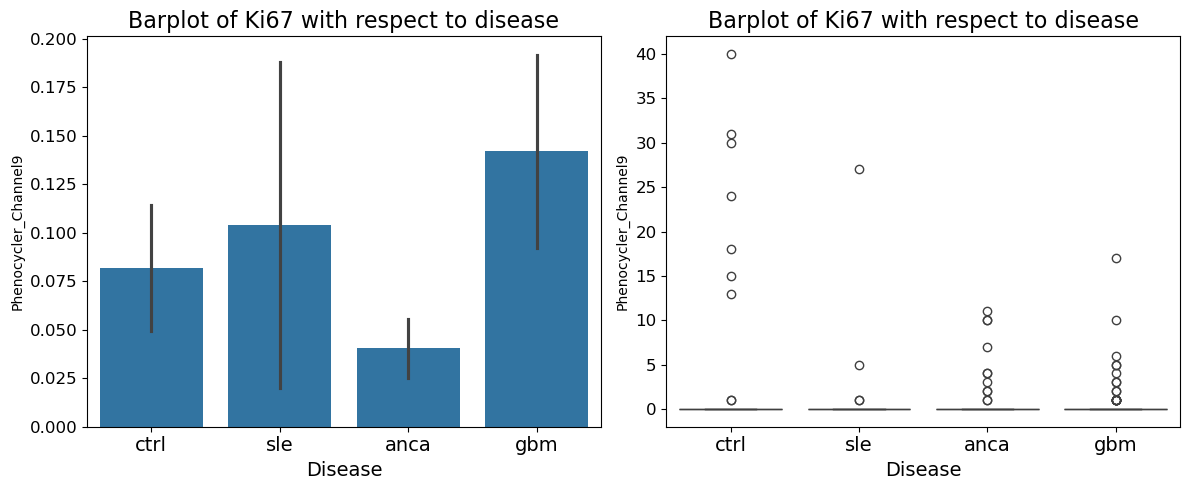

In [912]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Phenocycler_Channel9'
sns.barplot(x='label', y=ch, data=df, ax=axes[0], errorbar='se', order=disease_order)
axes[0].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='label', y=ch, data=df, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

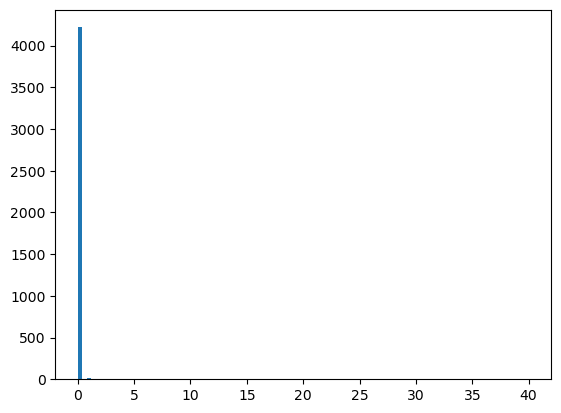

In [913]:
plt.hist(df[ch], 100);
# plt.ylim([0, 10])

(0.0, 10.0)

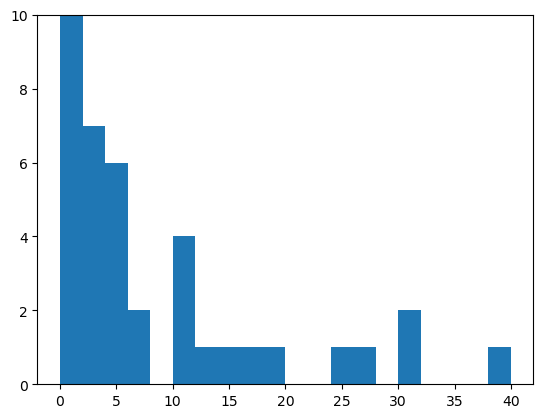

In [914]:
plt.hist(df[ch], 20)
plt.ylim([0, 10])

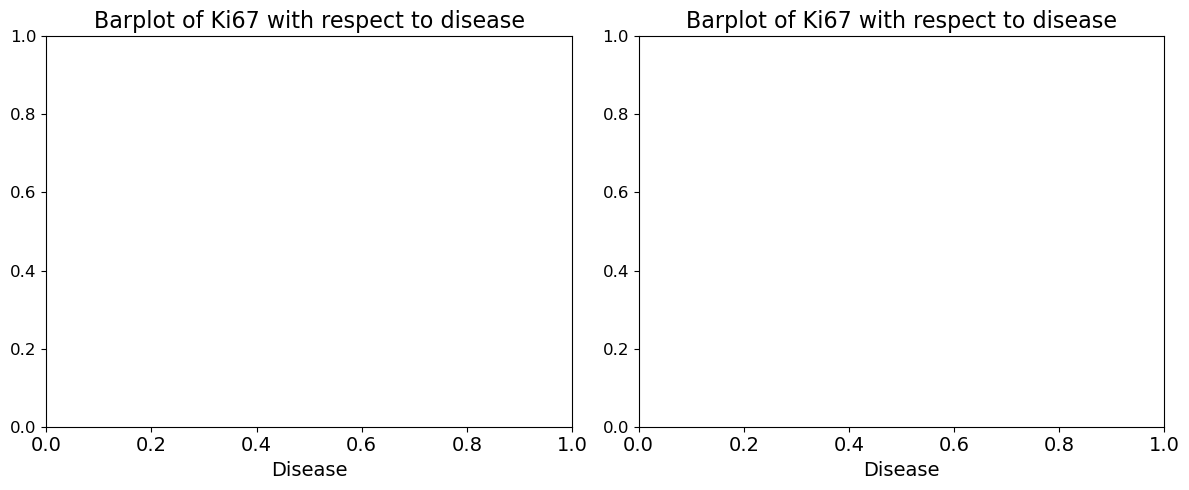

In [921]:
df_new = df.loc[df[ch] > 2]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Phenocycler_Channel9'
sns.barplot(x='label', y=ch, data=df_new, ax=axes[0], errorbar='se', order=disease_order)
axes[0].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='label', y=ch, data=df_new, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

In [934]:
df = df.reset_index(drop=True)
# df.insert(1, 'Ki67_prc', 0)
th = 5
df.loc[:, 'Ki67_prc'] = [1.0 if i>th else 0.0 for i in df['Phenocycler_Channel9']]
df['Ki67_prc'].sum()

15.0

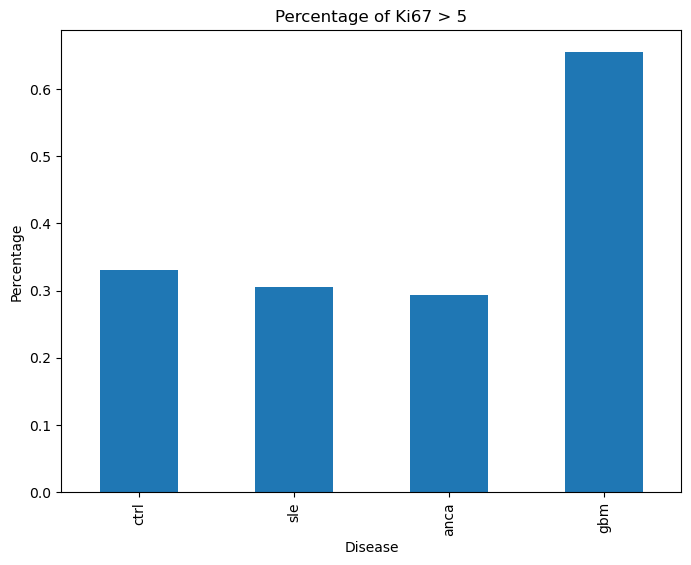

In [935]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Ki67_prc'
percent = df.groupby('label')[ch].mean() * 100
percent = percent.reindex(disease_order)
percent.plot(kind='bar', figsize=(8, 6))

plt.title(f'Percentage of Ki67 > {th}')
plt.xlabel('Disease')
plt.ylabel('Percentage')
plt.show()

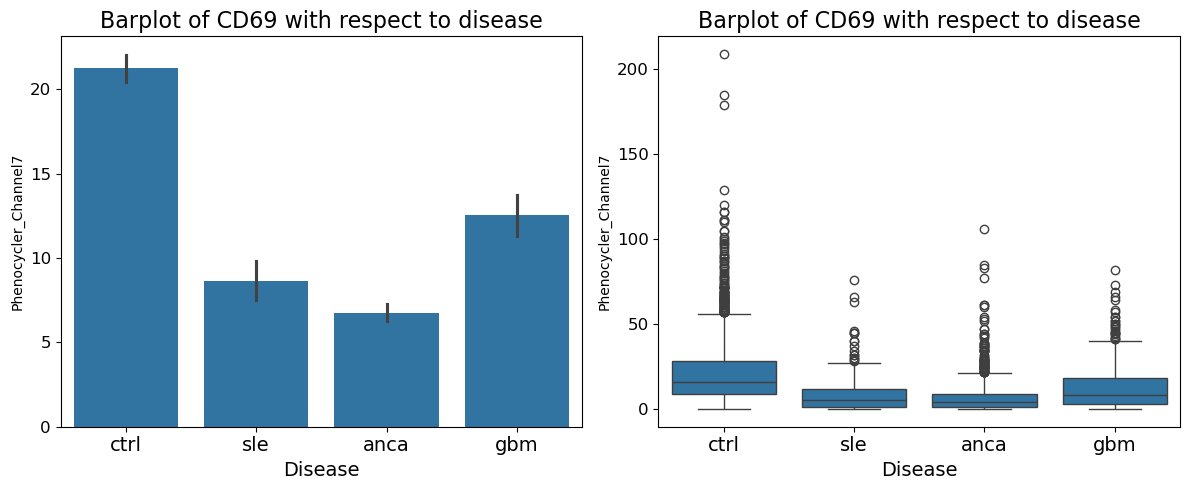

In [467]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Phenocycler_Channel7'
sns.barplot(x='label', y=ch, data=df, ax=axes[0], order=disease_order)
axes[0].set_title('Barplot of CD69 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='label', y=ch, data=df, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of CD69 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

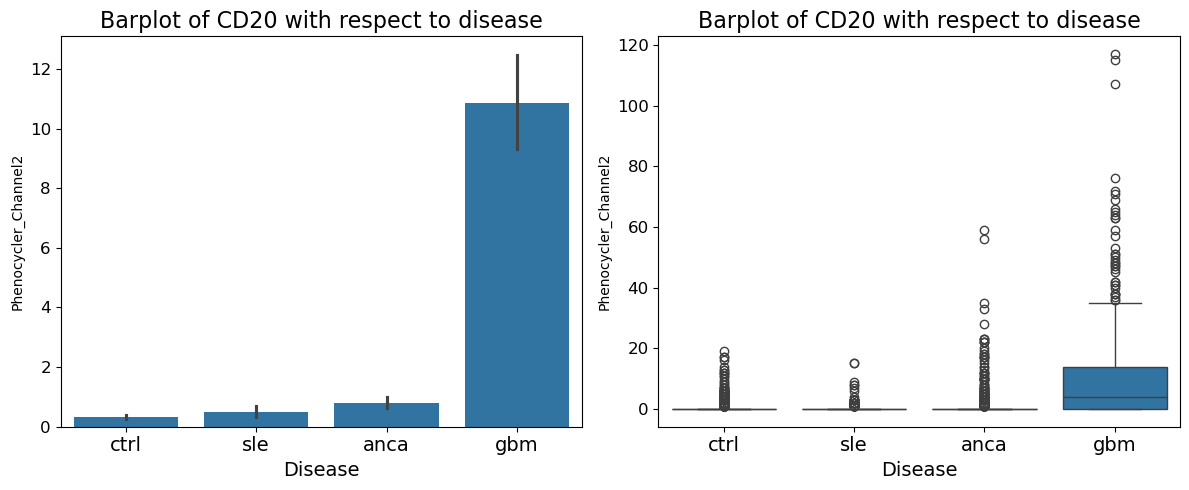

In [214]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Phenocycler_Channel2'
sns.barplot(x='label', y=ch, data=df, ax=axes[0], order=disease_order)
axes[0].set_title('Barplot of CD20 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='label', y=ch, data=df, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of CD20 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

In [721]:
adata_robin = sc.read_h5ad("/data/projects/robin/robin_xenium_cgn_from_epyc/seperate_dapi_samples/with_protein.h5ad")

In [722]:
# adata_robin = adata_robin[adata_robin.obs['Sample_num'] != 'X7']
adata_robin = adata_robin[adata_robin.obs['celltype_l1'] == 'PEC']

In [723]:
disease_order = ['Cntrl', 'Sle', 'Anca', 'Gbm']
df = adata_robin.obs
df['label'] = pd.Categorical(df['Disease'], categories=disease_order, ordered=True)

In [724]:
df['label'] = pd.Categorical(df['Disease'], categories=disease_order, ordered=True)

(0.0, 10.0)

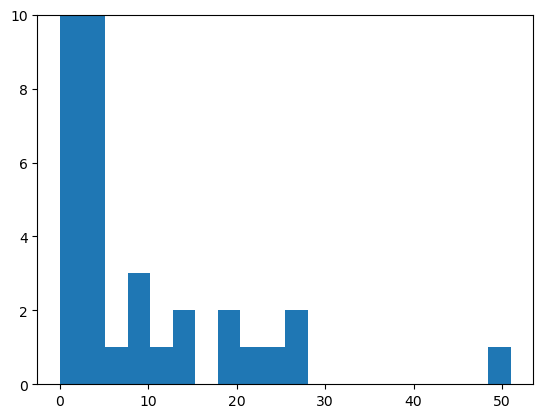

In [725]:
ch = 'Ki67_p'
plt.hist(df[ch], 20)
plt.ylim([0, 10])

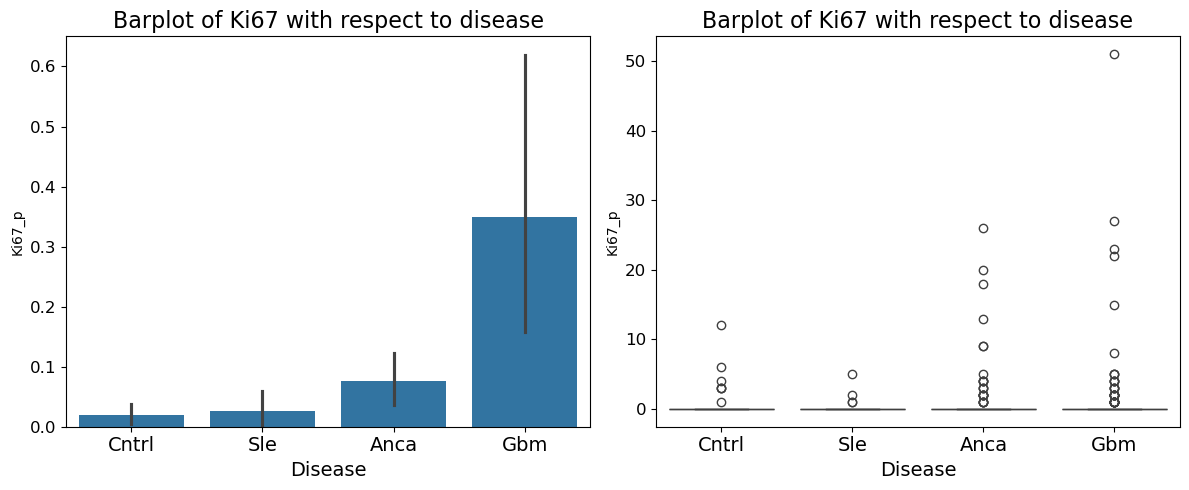

In [726]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Ki67_p'
sns.barplot(x='Disease', y=ch, data=df, ax=axes[0], order=disease_order)
axes[0].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='Disease', y=ch, data=df, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

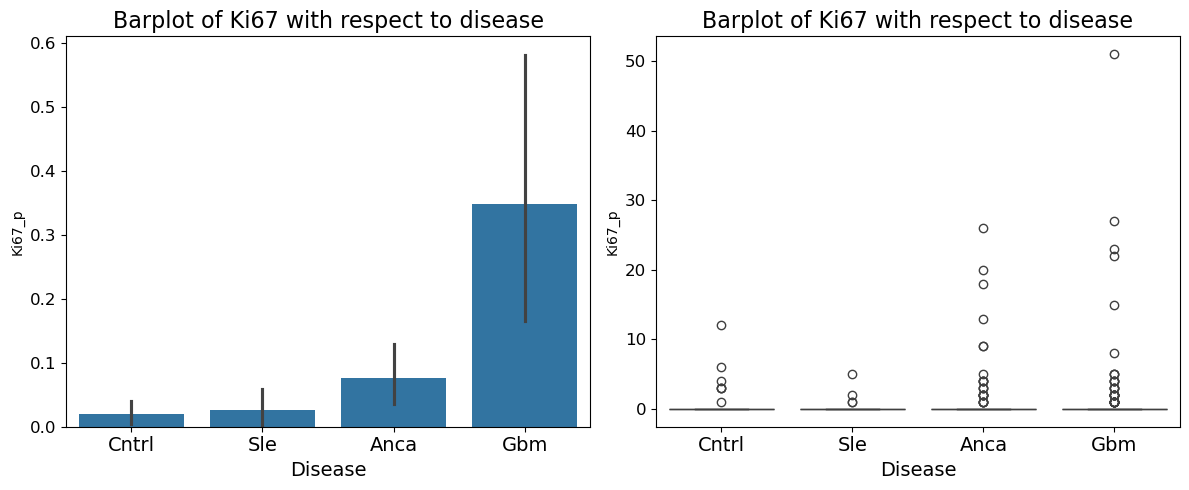

In [727]:
df_new = df.loc[df['Ki67_p'] >= 0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Ki67_p'
sns.barplot(x='Disease', y=ch, data=df_new, ax=axes[0], order=disease_order)
axes[0].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='Disease', y=ch, data=df_new, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

In [730]:
df = df.reset_index(drop=True)
df.loc[:, 'Ki67_prc'] = [1.0 if i>6 else 0.0 for i in df['Ki67_p']]
df['Ki67_prc'].sum()

13.0

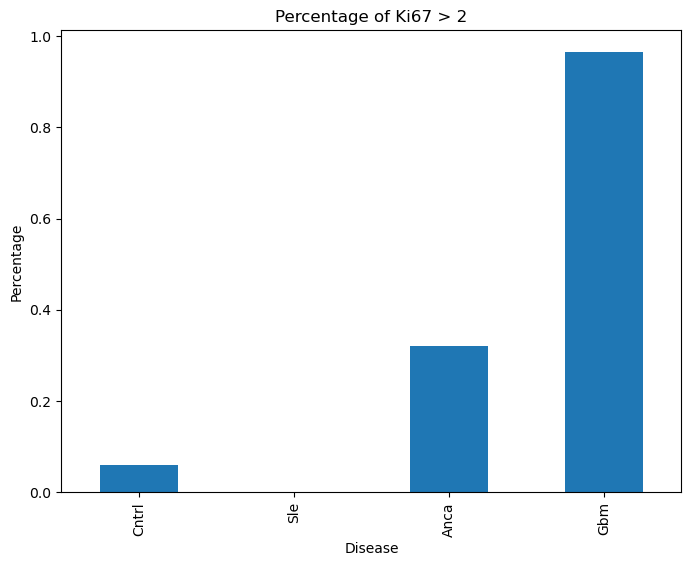

In [732]:
ch = 'Ki67_prc'
percent = df.groupby('Disease')[ch].mean() * 100
percent = percent.reindex(disease_order)
percent.plot(kind='bar', figsize=(8, 6))

plt.title('Percentage of Ki67 > 2')
plt.xlabel('Disease')
plt.ylabel('Percentage')
plt.show()

In [548]:
adata_all.obs.loc[adata_all.obs['label'] == 'sle', 'sample']

cell_CR9fbacb852-12121-1-0    X7
cell_CR9fbacb852-13226-1-0    X7
cell_CR9fbacb852-13244-1-0    X7
cell_CR9fbacb852-13263-1-0    X7
cell_CR9fbacb852-13268-1-0    X7
                              ..
cell_CR9fbacb852-344264-1     X8
cell_CR9fbacb852-344326-1     X8
cell_CR9fbacb852-344371-1     X8
cell_CR9fbacb852-344671-1     X8
cell_CR9fbacb852-344894-1     X8
Name: sample, Length: 26634, dtype: category
Categories (8, object): ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']

In [858]:
i = np.where(cell_names == '344894')[0].item()
poly_i = np.array(cell_coordinates[i])
poly_i[:,0], poly_i[:,1]

(array([3521.6711, 3522.5667, 3519.4448, 3518.621 , 3518.3726, 3519.4453,
        3519.8542, 3521.6711]),
 array([1183.9215, 1183.3866, 1181.8112, 1180.7463, 1182.4324, 1183.1168,
        1183.2418, 1183.9215]))

In [841]:
adata_all.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,Phenocycler_Channel6,Phenocycler_Channel7,Phenocycler_Channel8,Phenocycler_Channel9,Phenocycler_Channel10,Phenocycler_Channel11,Phenocycler_Channel12,Phenocycler_Channel13,batch,cell_name
cell_CR9fbacb852-172697-0-0-0-0-0-0-0,5686.630300,16243.587750,32.710325,4,8,0.3695,3.021,21.650,0.9724,0.9025,...,0,0,0,0,0,0,0,0,0,172697
cell_CR9fbacb852-183840-0-0-0-0-0-0-0,5533.867400,17797.181667,28.890549,3,6,0.8171,4.300,7.343,0.9859,0.9700,...,0,0,0,0,0,0,0,0,0,183840
cell_CR9fbacb852-183965-0-0-0-0-0-0-0,5544.457950,17818.821750,27.178570,3,8,2.2230,2.835,3.599,0.9743,0.9775,...,0,0,0,0,0,0,0,0,0,183965
cell_CR9fbacb852-184398-0-0-0-0-0-0-0,7113.689200,16393.493100,23.298814,4,10,1.3270,1.694,7.536,0.9939,0.9780,...,0,1,0,0,0,0,1,0,0,184398
cell_CR9fbacb852-185040-0-0-0-0-0-0-0,7705.488675,16117.277875,23.637515,4,12,1.7790,1.445,6.745,0.9983,0.9950,...,0,1,0,0,0,0,2,0,0,185040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CR9fbacb852-344264-1,2479.081464,3356.340695,39.132713,4,22,1.1450,5.912,19.220,0.9983,0.7436,...,0,4,4,0,0,49,0,0,1,344264
cell_CR9fbacb852-344326-1,3378.595655,985.457752,42.317890,1,29,0.4470,1.583,64.880,0.9891,0.7048,...,0,0,0,0,0,4,0,0,1,344326
cell_CR9fbacb852-344371-1,3434.533961,874.129657,40.304167,4,28,0.5554,2.315,50.410,0.9917,0.7014,...,0,0,0,0,0,6,0,0,1,344371
cell_CR9fbacb852-344671-1,2246.205632,1924.905336,39.431705,1,22,0.7353,3.803,29.920,0.9965,0.6064,...,0,1,1,0,0,0,1,0,1,344671


In [860]:
i, j = adata_all.obsm["spatial"][0]

In [846]:
pc_image[int(j), int(i)]

0

In [863]:
int(np.round(i))

722